# Term frequency - Inverse document frequency (TF-IDF)

In [11]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext dotenv
%dotenv

import suggester as sg

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## 1. Setup project

### 1.1. Environment setup

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### 1.2. Setup dataset generator

In [13]:
import suggester as sg

_config = sg.SearchConfig(
  api_key=os.getenv("AI_API_KEY"),
  model=os.getenv("AI_MODEL"),
  base_url=os.getenv("AI_MODEL_URL"),
  cache_dir="../build/cache")
_engineer = sg.SearchDataEngineer(_config)

train_context = await _engineer.generate_data(route_context="travel agency", route_count=10, session_count=50)

## 2. Build route recommender 

In [14]:
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class RouteRecommender:
    def __init__(self, context: sg.NavigationContext):
        self.context = context
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

        self.route_data = self._prepare_route_data(context)
        self.route_documents = [data['document'] for data in self.route_data]
        self.route_vectors = self.vectorizer.fit_transform(self.route_documents)

    def _prepare_route_data(self, context: sg.NavigationContext):
        _routes = context.routes.copy()
        _routes_data = []

        for route in _routes:
            route_document = []
            for path in route.path.split('/'):
                if path not in string.punctuation:
                    route_document.append(path)

            for tag in route.tags:
                route_document.append(tag)

            _sessions = context.sessions.copy()
            for i, session in enumerate(_sessions):
                if session.route_id == route.id:
                    route_document.append(session.intention.context)
                    _sessions.pop(i)

            _routes_data.append({
                'id': route.id,
                'path': route.path,
                'document': ' '.join(route_document)
            })

        return _routes_data

    def recommend_route(self, query: str, top_n=3):
        query_vec = self.vectorizer.transform([query])

        scores = cosine_similarity(query_vec, self.route_vectors).flatten()

        sorted_indices = np.argsort(scores)[::-1][:top_n]

        return [(self.route_data[i], scores[i]) for i in sorted_indices]

## 3. Validate route recommender 

### 3.1. Test route recommender

In [15]:
import time

_context = train_context
recommender = RouteRecommender(_context)

def _test_query(query):
    start_time = time.time()
    results = recommender.recommend_route(query)
    latency = (time.time() - start_time)*1000

    print(f"Results ({latency:.2f}ms):")
    for route, score in results:
        print(f"- {route["id"]} | {route["path"]} (score: {score:.3f})")

for session in _context.sessions:
    route_id = session.route_id
    query = session.intention.context
    print(f"Query: '{query}'; Expected route: {route_id};")
    _test_query(query)


AttributeError: 'list' object has no attribute 'lower'

### 3.2. Analyze route recommender

In [6]:
print("Vocabulary size:", len(recommender.vectorizer.vocabulary_))
print("Vector size:", sys.getsizeof(recommender.route_vectors))

Vocabulary size: 170
Vector size: 48


### 3.2. Analyze route similarity

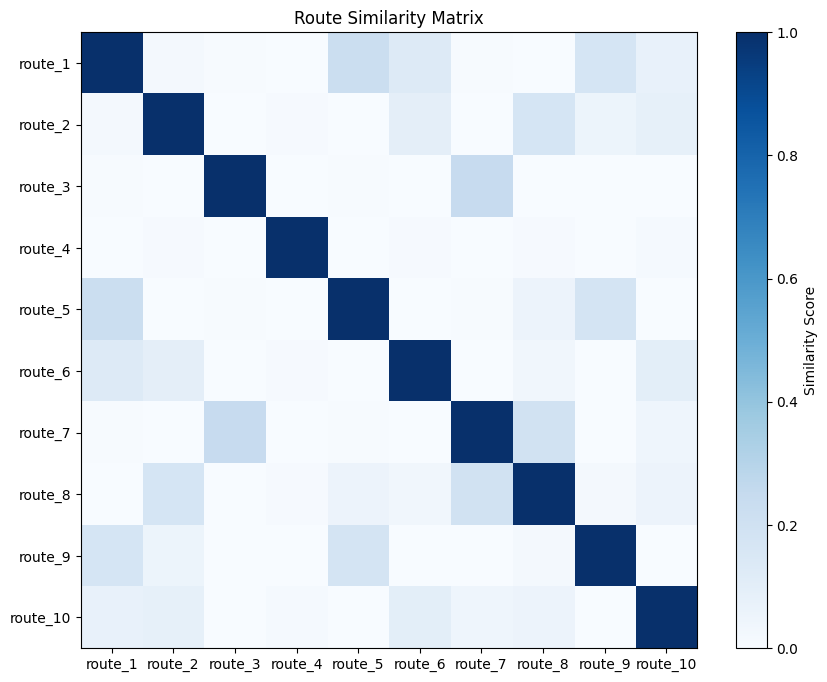

In [7]:
import matplotlib.pyplot as plt

similarity_matrix = cosine_similarity(recommender.route_vectors)

plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap="Blues")

_test_routes = recommender.context.routes
plt.colorbar(label="Similarity Score")
plt.xticks(ticks=range(len(_test_routes)), labels=[r.id for r in _test_routes])

plt.title("Route Similarity Matrix")
plt.yticks(ticks=range(len(_test_routes)), labels=[r.id for r in _test_routes])
plt.show()